In [1]:
import torch
import torchvision
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda")

In [3]:
from constant import CONFIG

CONFIG

SAMConfig(sam2_checkpoint='../sam2/checkpoints/sam2.1_hiera_large.pt', model_cfg='../sam2/configs/sam2.1/sam2.1_hiera_l.yaml')

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = CONFIG.sam2_checkpoint
model_cfg = CONFIG.model_cfg

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [6]:
import cv2
import os
from pathlib import Path
from utils.split_video import split_video


# Path to the video file
video_path = Path(r"C:\Users\AORUS\Desktop\program\gif_generator\assests\videoplayback.mp4")
split_video(video_path)



Frames extracted and saved to temp\test


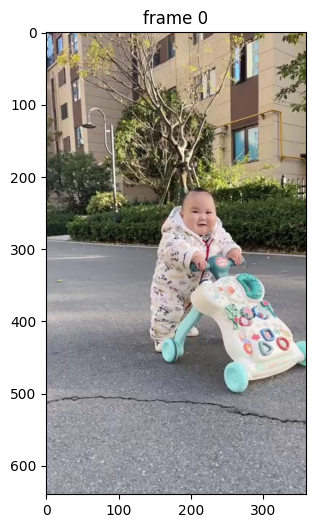

In [7]:
from constant import SPLIT_OUTPUT
inference_state = predictor.init_state(video_path=SPLIT_OUTPUT)

frame loading (JPEG): 100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


In [8]:
predictor.reset_state(inference_state)

In [9]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)


C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\s

In [10]:
from utils.segement import video_segement, show_segement

video_segements = video_segement(predictor=predictor, inference_state=inference_state)

propagate in video:   0%|          | 0/151 [00:00<?, ?it/s]C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 151/151 [01:25<00:00,  1.76it/s]


In [14]:
show_segement(30,151,video_segements)

ValueError: cannot determine region size; use 4-item box

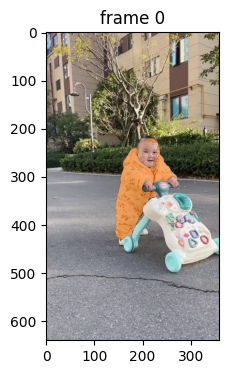

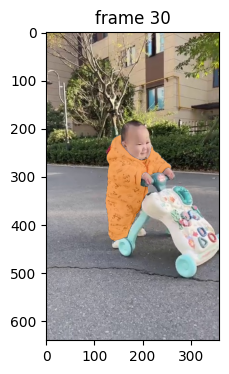

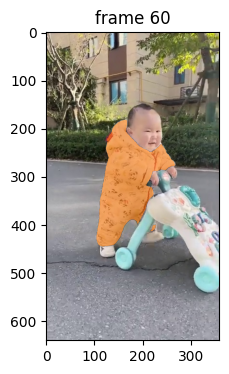

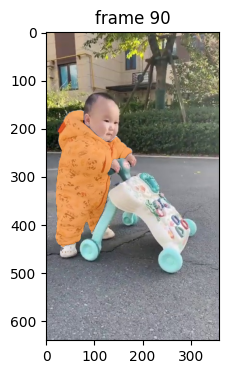

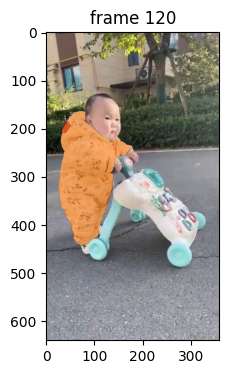

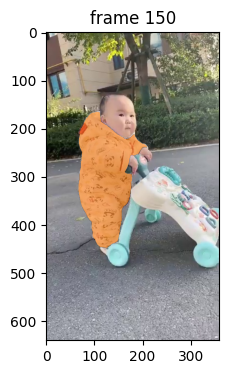

In [13]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, 151, vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}") 
    plt.imshow(Image.open(os.path.join(SPLIT_OUTPUT, f"{out_frame_idx:04d}.jpg")))
    for out_obj_id, out_mask in video_segements[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [34]:
PNG_OUTPUT_DIR = os.path.join("temp","mask") # Adjust this to where you want to save the PNGs


# Ensure the PNG output directory exists
os.makedirs(PNG_OUTPUT_DIR, exist_ok=True)

vis_frame_stride = 1

# Ensure output directory exists
if not os.path.exists(PNG_OUTPUT_DIR):
    os.makedirs(PNG_OUTPUT_DIR)


for out_frame_idx in range(0, 341, vis_frame_stride):
    # Load the original image (background)
    img_path = os.path.join(SPLIT_OUTPUT, f"{out_frame_idx:04d}.jpg")
    
    # Check if image exists to prevent errors
    if not os.path.exists(img_path):
        print(f"Skipping frame {out_frame_idx}: Image not found.")
        continue

    img = Image.open(img_path).convert("RGBA")  # Convert to RGBA to handle transparency
    img_np = np.array(img)  # Convert to a NumPy array

    # Create an empty (transparent) 4D numpy array of the same size
    # The shape of img_np is (height, width, 4) because it's RGBA
    empty_array = np.zeros_like(img_np)  # Fully transparent (0s for RGBA)

    # Iterate through the segmented objects in this frame and extract the mask areas
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # Ensure the mask is a 2D binary array (height x width)
        out_mask = np.squeeze(out_mask)  # Remove unnecessary dimensions
        out_mask = (out_mask * 255).astype(np.uint8)  # Convert to 255 for visibility

        # Create a binary mask (0s and 255s) based on the mask
        mask = Image.fromarray(out_mask)

        # Create a NumPy array from the mask (size should be (height, width))
        mask_np = np.array(mask)

        # Extract the masked region from the original image
        # Using the mask, add the masked region to the empty array (transparency where no mask)
        empty_array[mask_np == 255] = img_np[mask_np == 255]

    # Convert the final result to an image
    result_img = Image.fromarray(empty_array)

    # Prepare the output PNG file path
    png_filename = f"{out_frame_idx:04d}_masked.png"
    png_path = os.path.join(PNG_OUTPUT_DIR, png_filename)

    # Save the final result as a PNG (masked areas only visible)
    result_img.save(png_path)

    print(f"Saved {png_filename} as PNG")

Saved 0000_masked.png as PNG
Saved 0001_masked.png as PNG
Saved 0002_masked.png as PNG
Saved 0003_masked.png as PNG
Saved 0004_masked.png as PNG
Saved 0005_masked.png as PNG
Saved 0006_masked.png as PNG
Saved 0007_masked.png as PNG
Saved 0008_masked.png as PNG
Saved 0009_masked.png as PNG
Saved 0010_masked.png as PNG
Saved 0011_masked.png as PNG
Saved 0012_masked.png as PNG
Saved 0013_masked.png as PNG
Saved 0014_masked.png as PNG
Saved 0015_masked.png as PNG
Saved 0016_masked.png as PNG
Saved 0017_masked.png as PNG
Saved 0018_masked.png as PNG
Saved 0019_masked.png as PNG
Saved 0020_masked.png as PNG
Saved 0021_masked.png as PNG
Saved 0022_masked.png as PNG
Saved 0023_masked.png as PNG
Saved 0024_masked.png as PNG
Saved 0025_masked.png as PNG
Saved 0026_masked.png as PNG
Saved 0027_masked.png as PNG
Saved 0028_masked.png as PNG
Saved 0029_masked.png as PNG
Saved 0030_masked.png as PNG
Saved 0031_masked.png as PNG
Saved 0032_masked.png as PNG
Saved 0033_masked.png as PNG
Saved 0034_mas

In [4]:
import cv2
import imageio
import os

gif_path = "output_animation.gif"

# Get the list of PNG files and sort them
frame_names = sorted(os.listdir(PNG_OUTPUT_DIR))

# Create a list to hold the frames
frames = []

# Loop through the sorted frame names and load each image
for frame_name in frame_names:
    frame_path = os.path.join(PNG_OUTPUT_DIR, frame_name)
    
    # Load the image with OpenCV (keeping transparency if present)
    img = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)  # Read the image as is (including transparency if present)
    
    # Convert to RGBA if it has an alpha channel (keeping transparency intact)
    if img.shape[2] == 4:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)  # Convert BGRA to RGBA (if it has alpha)
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # If no alpha, just convert to RGB
    
    # Append the frame to the list (each frame is independent)
    frames.append(img_rgb)

# Use imageio to write the GIF from the frames
imageio.mimsave(gif_path, frames, duration=0.1)  # Each frame will be shown for 0.1 seconds

print(f"GIF saved to {gif_path}")

GIF saved to output_animation.gif


In [16]:
import cv2
import imageio
import numpy as np

# Path to the directory containing expanded images
expanded_images_folder = 'temp/mask'

# Target GIF size
target_width, target_height = 360, 640

# List to store all frames
frames = []

# Iterate through the expanded images
for i in range(141):
    # Read each expanded image
    img = cv2.imread(f'{expanded_images_folder}/{i:04d}_masked.png', cv2.IMREAD_UNCHANGED)

    # Ensure the image is loaded correctly
    if img is not None:
        img_height, img_width = img.shape[:2]

        # Create a fully transparent background canvas
        canvas = np.zeros((target_height, target_width, 4), dtype=np.uint8)
        canvas[..., 3] = 0  # Ensure canvas is fully transparent (alpha channel)

        # Calculate the offsets to center the image
        y_offset = (target_height - img_height) // 2
        x_offset = (target_width - img_width) // 2

        # Overlay the image onto the canvas
        canvas[y_offset:y_offset + img_height, x_offset:x_offset + img_width] = img

        # Convert from BGRA to RGBA (necessary for imageio)
        img_rgba = cv2.cvtColor(canvas, cv2.COLOR_BGRA2RGBA)

        # Append the frame to the list
        frames.append(img_rgba)

# Save all frames as a GIF with frame disposal method 2 (clear previous frame)
output_gif_path = 'output.gif'
imageio.mimsave(
    output_gif_path,
    frames,
    format='GIF',
    duration=0.1,  # Frame duration (seconds)
    loop=0,        # Loop forever
    transparency=0,  # Set transparency to 0 (transparent background)
    disposal=2      # Disposal method 2: clear previous frame before displaying the next
)

print(f"GIF saved as '{output_gif_path}'")


GIF saved as 'output.gif'
